In [3]:
import configparser
import logging
import os
import time
from datetime import datetime

import transf_producao
from database import registrar_extracao
from selenium import webdriver
from selenium.common.exceptions import StaleElementReferenceException
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager

# Configura o logger
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler("teste.log"), logging.StreamHandler()],
)

logger = logging.getLogger()

# Carregar o arquivo de configuração
config = configparser.ConfigParser()
config.read("config.ini")

# Diretórios de destino e download
transformacao_dir = config["Paths"]["transformacao_dir"]
download_dir = config["Paths"]["download_dir"]

# Gerar o nome do arquivo esperado dinamicamente
today = datetime.today().strftime("%Y-%m-%d")
PRODUCAO_FILENAME = "RelatorioSaudeProducao.csv"


def configurar_driver():
    """Configura e retorna o driver do Chrome."""
    options = Options()
    # options.add_argument('--headless')
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_experimental_option(
        "prefs",
        {
            "profile.default_content_settings.popups": 0,  # Desativa popups de download
            "download.prompt_for_download": False,  # Não pergunta onde salvar
            "download.directory_upgrade": True,  # Atualiza o diretório automaticamente
            "safebrowsing.enabled": True,  # Habilita o Safe Browsing
            "profile.default_content_setting_values.automatic_downloads": 1,  # Permite múltiplos downloads
        },
    )
    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()), options=options
    )
    return driver


def seleciona_xpath(driver, xpath):
    """Seleciona o elemento com o xpath"""
    try:
        seleciona = WebDriverWait(driver, 3).until(
            EC.presence_of_element_located(("xpath", xpath))
        )
        seleciona.click()
        return True
    except StaleElementReferenceException:
        return False


def selecionar_primeiro_item(driver, butao_xpath):
    """Seleciona a primeira coluna para download."""
    try:
        item_xpath = butao_xpath[:-6] + "ul/li[1]/a/label/input"
        # Encontra o botão e clica
        button = WebDriverWait(driver, 3).until(
            EC.element_to_be_clickable((By.XPATH, butao_xpath))
        )
        button.click()
        # Seleciona o item
        item = WebDriverWait(driver, 3).until(
            EC.presence_of_element_located(("xpath", item_xpath))
        )
        if item.is_selected():
            return True
        item.click()
        return True
    except StaleElementReferenceException:
        return False


def clica_download(driver):
    """Clica no botão de download."""
    try:
        # Iniciar o download
        download_button = driver.find_element(
            By.XPATH,
            '//*[@id="j_idt44"]/div/div[1]/div/div[2]/div[2]/div[5]/div/div/div[2]/button',
        )
        driver.execute_script("arguments[0].click();", download_button)

        # Esperar o botão CSV estar clicável
        csv_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (
                    By.XPATH,
                    '//*[@id="j_idt44"]/div/div[1]/div/div[2]/div[2]/div[5]/div/div/div[2]/ul/li[2]/a',
                )
            )
        )
        driver.execute_script("arguments[0].click();", csv_button)
        return True
    except StaleElementReferenceException:
        return False


def espera_download(
    mes,
    nome_arq,
    download_dir=download_dir,
    expected_filename=PRODUCAO_FILENAME,
):
    """Espera o download do arquivo."""
    # Caminho completo para o arquivo esperado
    expected_file_path = os.path.join(download_dir, expected_filename)

    # Tempo máximo para esperar o download, em segundos
    timeout = 180
    start_time = time.time()

    # Esperar até que o arquivo apareça na pasta de downloads
    while True:
        if os.path.exists(expected_file_path):
            # Se o arquivo existir, verificar se o download foi concluído
            if not expected_file_path.endswith(".crdownload"):
                logger.info(f"Download completo: {expected_filename}")
                n_mes = mes.replace("/", "-")
                # Mover o arquivo para diretório de dados
                os.rename(
                    expected_file_path,
                    f"{transformacao_dir}/{nome_arq}_{n_mes}.csv",
                )
            return True
        elif time.time() - start_time > timeout:
            # Se o tempo de espera exceder o timeout, exibir uma mensagem de erro
            print(
                f"Tempo limite excedido para download de {expected_filename}."
            )
            return False
        time.sleep(1)  # Esperar 1 segundo antes de verificar novamente


def fazer_download(
    driver,
    mes,
    nome_arq,
    download_dir=download_dir,
    expected_filename=PRODUCAO_FILENAME,
):
    """Faz o download do relatório em formato CSV e espera até que o download esteja completo."""
    logger.info(f"Fazendo download do relatório para {mes}")

    # Inicia o download
    clica_download(driver)

    # Aguarda o arquivo ser baixado
    if not espera_download(mes, nome_arq, download_dir, expected_filename):
        return False
    return True


def seleciona_competencias(driver):
    """Seleciona a competência (mes/ano)"""

    # Clica no botão de de competência (mes/ano)
    competencia_element = WebDriverWait(driver, 3).until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="competencia"]/div/button')
        )
    )
    competencia_element.click()
    # Aguarda a lista de competências aparecer
    competencias = WebDriverWait(driver, 3).until(
        EC.presence_of_element_located(
            ("xpath", '//*[@id="competencia"]/div/ul')
        )
    )
    return competencias


def cria_driver():
    """Cria o driver do Chrome."""
    driver = configurar_driver()
    logger.info("Iniciando o acesso a página de Producao do SISAB")
    driver.get(
        "https://sisab.saude.gov.br/paginas/acessoRestrito/relatorio/federal/saude/RelSauProducao.xhtml"
    )
    return driver




In [9]:
def seleciona_sigtab(driver, codigo):
    """Seleciona o SIGTAB"""
    try:
       # Clicar no botão de adicionar SIGTAB
        sigtab_button = driver.find_element(
            By.XPATH,
            '//*[@id="btnAddSigtap"]',
        )
        driver.execute_script("arguments[0].click();", sigtab_button)

        # escrever o código do SIGTAB
        sigtab_input = WebDriverWait(driver, 3).until(
            EC.presence_of_element_located(
                (By.XPATH, '//*[@id="td-ls-sigtap_filter"]/label/input')
            )
        )

        # Preencher o campo com o código do SIGTAB
        sigtab_input.send_keys(codigo)

        # seleciona o checkbox
        sigtab_checkbox = WebDriverWait(driver, 3).until(
            EC.presence_of_element_located(
                (By.XPATH, '//*[@id="td-ls-sigtap"]/tbody/tr/td/label/input')
            )
        )

        if not sigtab_checkbox.is_selected():
            sigtab_checkbox.click()
        

        return True
    except StaleElementReferenceException:
        return False


def seleciona_cid(driver, codigo):
    """Seleciona o SIGTAB"""
    try:
       # Clicar no botão de adicionar SIGTAB
        sigtab_button = driver.find_element(
            By.XPATH,
            '//*[@id="btnAddSigtap"]',
        )
        driver.execute_script("arguments[0].click();", sigtab_button)

        # escrever o código do SIGTAB
        sigtab_input = WebDriverWait(driver, 3).until(
            EC.presence_of_element_located(
                (By.XPATH, '//*[@id="td-ls-sigtap_filter"]/label/input')
            )
        )

        # Preencher o campo com o código do SIGTAB
        sigtab_input.send_keys(codigo)

        # seleciona o checkbox
        sigtab_checkbox = WebDriverWait(driver, 3).until(
            EC.presence_of_element_located(
                (By.XPATH, '//*[@id="td-ls-sigtap"]/tbody/tr/td/label/input')
            )
        )

        if not sigtab_checkbox.is_selected():
            sigtab_checkbox.click()
        

        return True
    except StaleElementReferenceException:
        return False
    


def executar_sigtap(linha, coluna, codigo, nome_arq):
    """Executa o download dos relatórios de produção para cada mês."""
    # Inicializa o driver
    driver = cria_driver()
    # Esperar a página carregar
    wait = WebDriverWait(driver, 10)

    # Clica no botão de de competência (mes/ano)
    competencia_element = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="competencia"]/div/button')
        )
    )
    driver.execute_script("arguments[0].click();", competencia_element)

    competencias = wait.until(
        EC.presence_of_element_located(
            ("xpath", '//*[@id="competencia"]/div/ul')
        )
    )
    falhas = 0
    for j in range(len(competencias.find_elements(By.TAG_NAME, "li"))):
        # recarregar competencias
        if j > 0:
            competencias = seleciona_competencias(driver)
        for i, competencia in enumerate(
            competencias.find_elements(By.TAG_NAME, "li")
        ):
            if i == j:
                mes = competencia.text
                # pegar o horario de inicio em timestamp

                logger.info(f"Processando o mês {mes}")
                # Clica no botão de de competência (mes/ano)

                competencia.click()

                # Selecionar "Municípios" no dropdown de Linhas
                seleciona_xpath(driver, linha)

                # Selecionar "Condição Avaliada" no dropdown de Colunas
                seleciona_xpath(driver, coluna)

                # Selecionar o SIGTAB
                seleciona_sigtab(driver, codigo)

                

        break

    time.sleep(10)
    logger.info("Script Finalizado")
    # Fecha a janela do navegador
    driver.quit()

"""
executar_sigtap(
    '//*[@id="selectLinha"]/optgroup[1]/option[5]',
    '//*[@id="selectcoluna"]/optgroup[4]/option[3]',
    '0301040141', 'teste')
"""


2024-08-25 16:41:39,306 - INFO - ====== WebDriver manager ======
2024-08-25 16:41:39,369 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-25 16:41:39,409 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-25 16:41:39,443 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.84/chromedriver-linux64/chromedriver] found in cache
2024-08-25 16:41:40,027 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-25 16:41:42,528 - INFO - Processando o mês JUN/2024


ElementNotInteractableException: Message: element not interactable
  (Session info: chrome=128.0.6613.84)
Stacktrace:
#0 0x55dc25eb981a <unknown>
#1 0x55dc25b87c91 <unknown>
#2 0x55dc25bd1618 <unknown>
#3 0x55dc25bcfa8d <unknown>
#4 0x55dc25bfc492 <unknown>
#5 0x55dc25bcbe89 <unknown>
#6 0x55dc25bfc65e <unknown>
#7 0x55dc25c1a9c6 <unknown>
#8 0x55dc25bfc233 <unknown>
#9 0x55dc25bca093 <unknown>
#10 0x55dc25bcb09e <unknown>
#11 0x55dc25e80a7b <unknown>
#12 0x55dc25e84a31 <unknown>
#13 0x55dc25e6c645 <unknown>
#14 0x55dc25e855a2 <unknown>
#15 0x55dc25e5181f <unknown>
#16 0x55dc25ea8618 <unknown>
#17 0x55dc25ea87e2 <unknown>
#18 0x55dc25eb860c <unknown>
#19 0x7fa930cdbac3 <unknown>


In [19]:
def fazer_download(
    driver,
    mes,
    nome_arq,
    download_dir=download_dir,
    expected_filename=PRODUCAO_FILENAME,
):
    """Faz o download do relatório em formato CSV e espera até que o download esteja completo."""
    logger.info(f"Fazendo download do relatório para {mes}")

    # Inicia o download
    clica_download(driver)

    # Aguarda o arquivo ser baixado
    if not espera_download(mes, nome_arq, download_dir, expected_filename):
        return False
    return True

def seleciona_cid(driver):
    """Seleciona o SIGTAB"""
    #try:
       # Clicar no botão de adicionar SIGTAB
    cid_button = driver.find_element(
        By.XPATH,
        '//*[@id="btnAddCid"]',
    )
    
    driver.execute_script("arguments[0].click();", cid_button)

    itens_por_pagina = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="dtBasicExample_length"]/label/select')
        )
    )
    itens_por_pagina.click()

    # Aguardar até que a opção de 100 itens esteja presente e clique nela
    opcao_100_itens = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="dtBasicExample_length"]/label/select/option[@value="100"]')
        )
    )
    opcao_100_itens.click()


    for j in range(20):
        # Selecionar todos os CIDs
        cids = WebDriverWait(driver, 3).until(
            EC.presence_of_element_located(
                (By.XPATH, '//*[@id="dtBasicExample"]/tbody')
            )
        )
        for i in range(len(cids.find_elements(By.TAG_NAME, "td"))):
            cid = WebDriverWait(driver, 3).until(
                EC.presence_of_element_located(
                    (By.XPATH, f'//*[@id="dtBasicExample"]/tbody/tr[{i+1}]/td[1]/label/input')
                )
            )
            cid.click()
        
        # Clica na próxima página
        proxima_pagina = WebDriverWait(driver, 3).until(
            EC.element_to_be_clickable(
                (By.XPATH, '//*[@id="dtBasicExample_next"]/a')
            )
        )
        proxima_pagina.click()
    
    # Clica no botão de concluir
    concluir_button = WebDriverWait(driver, 3).until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="modal-default-cid"]/div/div/div[2]/button[2]')
        )
    )
    concluir_button.click()     
    

    return True
    #except StaleElementReferenceException:
    #    return False
    


def executar_cid():
    """Executa o download dos relatórios de produção para cada mês."""
    # Inicializa o driver
    driver = cria_driver()
    # Esperar a página carregar
    wait = WebDriverWait(driver, 10)

    # Clica no botão de de competência (mes/ano)
    competencia_element = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="competencia"]/div/button')
        )
    )
    driver.execute_script("arguments[0].click();", competencia_element)

    competencias = wait.until(
        EC.presence_of_element_located(
            ("xpath", '//*[@id="competencia"]/div/ul')
        )
    )
    falhas = 0
    for j in range(len(competencias.find_elements(By.TAG_NAME, "li"))):
        # recarregar competencias
        if j > 0:
            competencias = seleciona_competencias(driver)
        for i, competencia in enumerate(
            competencias.find_elements(By.TAG_NAME, "li")
        ):
            if i == j:
                mes = competencia.text
                # pegar o horario de inicio em timestamp

                logger.info(f"Processando o mês {mes}")
                # Clica no botão de de competência (mes/ano)

                competencia.click()

                # Selecionar "Municípios" no dropdown de Linhas
                seleciona_xpath(driver, '//*[@id="selectLinha"]/optgroup[1]/option[5]')

                # Selecionar "CID" no dropdown de Colunas
                seleciona_xpath(driver, '//*[@id="selectcoluna"]/optgroup[2]/option[7]')

                # Selecionar o CIDs
                seleciona_cid(driver)

        fazer_download(driver, mes, "producao_cid")                

        break

    time.sleep(10)
    logger.info("Script Finalizado")
    # Fecha a janela do navegador
    driver.quit()


executar_cid()

"""
executar_sigtap(
    '//*[@id="selectLinha"]/optgroup[1]/option[5]',
    '//*[@id="selectcoluna"]/optgroup[4]/option[3]',
    '0301040141', 'teste')
"""


2024-08-27 18:23:31,906 - INFO - ====== WebDriver manager ======
2024-08-27 18:23:31,967 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-27 18:23:32,005 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-27 18:23:32,037 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.84/chromedriver-linux64/chromedriver] found in cache
2024-08-27 18:23:32,569 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-27 18:23:34,936 - INFO - Processando o mês JUN/2024
2024-08-27 18:25:45,358 - INFO - Fazendo download do relatório para JUN/2024


TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=128.0.6613.84)
Stacktrace:
#0 0x5621cd9e581a <unknown>
#1 0x5621cd6b3e50 <unknown>
#2 0x5621cd69be20 <unknown>
#3 0x5621cd69bb0d <unknown>
#4 0x5621cd699b11 <unknown>
#5 0x5621cd69a31f <unknown>
#6 0x5621cd6a9e3b <unknown>
#7 0x5621cd6c0204 <unknown>
#8 0x5621cd6c574b <unknown>
#9 0x5621cd69aa2e <unknown>
#10 0x5621cd6c0059 <unknown>
#11 0x5621cd746c2b <unknown>
#12 0x5621cd728233 <unknown>
#13 0x5621cd6f6093 <unknown>
#14 0x5621cd6f709e <unknown>
#15 0x5621cd9aca7b <unknown>
#16 0x5621cd9b0a31 <unknown>
#17 0x5621cd998645 <unknown>
#18 0x5621cd9b15a2 <unknown>
#19 0x5621cd97d81f <unknown>
#20 0x5621cd9d4618 <unknown>
#21 0x5621cd9d47e2 <unknown>
#22 0x5621cd9e460c <unknown>
#23 0x7fdb664daac3 <unknown>


In [2]:
def fazer_download(
    driver,
    mes,
    nome_arq,
    download_dir=download_dir,
    expected_filename=PRODUCAO_FILENAME,
):
    """Faz o download do relatório em formato CSV e espera até que o download esteja completo."""
    logger.info(f"Fazendo download do relatório para {mes}")

    # Inicia o download
    clica_download(driver)

    # Aguarda o arquivo ser baixado
    if not espera_download(mes, nome_arq, download_dir, expected_filename):
        return False
    return True


def seleciona_cid(driver, h):
    """Seleciona o SIGTAB"""
    #try:
       # Clicar no botão de adicionar SIGTAB
    cid_button = driver.find_element(
        By.XPATH,
        '//*[@id="btnAddCid"]',
    )
    
    driver.execute_script("arguments[0].click();", cid_button)

    itens_por_pagina = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="dtBasicExample_length"]/label/select')
        )
    )
    itens_por_pagina.click()

    # Aguardar até que a opção de 100 itens esteja presente e clique nela
    opcao_100_itens = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="dtBasicExample_length"]/label/select/option[@value="100"]')
        )
    )
    opcao_100_itens.click()


    for j in range(150):
        if j == h:
            # Selecionar todos os CIDs
            cids = WebDriverWait(driver, 3).until(
                EC.presence_of_element_located(
                    (By.XPATH, '//*[@id="dtBasicExample"]/tbody')
                )
            )
            for i in range(len(cids.find_elements(By.TAG_NAME, "td"))):
                cid = WebDriverWait(driver, 3).until(
                    EC.presence_of_element_located(
                        (By.XPATH, f'//*[@id="dtBasicExample"]/tbody/tr[{i+1}]/td[1]/label/input')
                    )
                )
                cid.click()
            
        # Clica na próxima página
        proxima_pagina = WebDriverWait(driver, 3).until(
            EC.element_to_be_clickable(
                (By.XPATH, '//*[@id="dtBasicExample_next"]/a')
            )
        )

        proxima_pagina.click()
        
        if j == h:
            # Clica no botão de concluir
            concluir_button = WebDriverWait(driver, 3).until(
                EC.element_to_be_clickable(
                    (By.XPATH, '//*[@id="modal-default-cid"]/div/div/div[2]/button[2]')
                )
            )
            concluir_button.click()
            break     
    

    return True
    #except StaleElementReferenceException:
    #    return False
    


def executar_cid():
    """Executa o download dos relatórios de produção para cada mês."""
    # Inicializa o driver
    driver = cria_driver()
    # Esperar a página carregar
    wait = WebDriverWait(driver, 10)

    # Clica no botão de de competência (mes/ano)
    competencia_element = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="competencia"]/div/button')
        )
    )
    driver.execute_script("arguments[0].click();", competencia_element)

    competencias = wait.until(
        EC.presence_of_element_located(
            ("xpath", '//*[@id="competencia"]/div/ul')
        )
    )
    competencias.click()
    for i in range(150)[70:]:
        try:
            if i > 0:
                competencias = seleciona_competencias(driver)

            for k, competencia in enumerate(
                competencias.find_elements(By.TAG_NAME, "li")[:7]
            ):
                competencia.click()

            # Selecionar "Municípios" no dropdown de Linhas
            seleciona_xpath(driver, '//*[@id="selectLinha"]/optgroup[1]/option[5]')

            # Selecionar "CID" no dropdown de Colunas
            seleciona_xpath(driver, '//*[@id="selectcoluna"]/optgroup[2]/option[7]')

            # Selecionar o CIDs
            seleciona_cid(driver, i)

            fazer_download(driver, f'12_meses_{i}', "producao_cid")
            driver.quit()
            driver = cria_driver()
        except Exception as e:
            print('Erro na execução: ', i)
            print(e)
            driver.quit()
            driver = cria_driver()
            continue
        

    time.sleep(10)
    logger.info("Script Finalizado")
    # Fecha a janela do navegador
    driver.quit()


executar_cid()



2024-08-28 08:00:12,665 - INFO - ====== WebDriver manager ======
2024-08-28 08:00:12,899 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-28 08:00:12,945 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-28 08:00:12,981 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.84/chromedriver-linux64/chromedriver] found in cache
2024-08-28 08:00:14,514 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-28 08:00:17,003 - INFO - ====== WebDriver manager ======
2024-08-28 08:00:17,057 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-28 08:00:17,089 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  70
Message: element not interactable
  (Session info: chrome=128.0.6613.84)
Stacktrace:
#0 0x5613f8dd481a <unknown>
#1 0x5613f8aa2c91 <unknown>
#2 0x5613f8af392f <unknown>
#3 0x5613f8ae74d6 <unknown>
#4 0x5613f8b17492 <unknown>
#5 0x5613f8ae6e89 <unknown>
#6 0x5613f8b1765e <unknown>
#7 0x5613f8b359c6 <unknown>
#8 0x5613f8b17233 <unknown>
#9 0x5613f8ae5093 <unknown>
#10 0x5613f8ae609e <unknown>
#11 0x5613f8d9ba7b <unknown>
#12 0x5613f8d9fa31 <unknown>
#13 0x5613f8d87645 <unknown>
#14 0x5613f8da05a2 <unknown>
#15 0x5613f8d6c81f <unknown>
#16 0x5613f8dc3618 <unknown>
#17 0x5613f8dc37e2 <unknown>
#18 0x5613f8dd360c <unknown>
#19 0x7fd917c67ac3 <unknown>



2024-08-28 08:00:17,123 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.84/chromedriver-linux64/chromedriver] found in cache
2024-08-28 08:00:17,685 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-28 08:00:34,197 - INFO - ====== WebDriver manager ======
2024-08-28 08:00:34,251 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-28 08:00:34,284 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  71
Message: element click intercepted: Element <input type="checkbox" onclick="addCid('O042-1')" id="cid-O042-1" name="cid-O042-1"> is not clickable at point (248, 1105). Other element would receive the click: <input type="checkbox" onclick="addCid('O056-1')" id="cid-O056-1" name="cid-O056-1">
  (Session info: chrome=128.0.6613.84)
Stacktrace:
#0 0x5555ed7dd81a <unknown>
#1 0x5555ed4abe50 <unknown>
#2 0x5555ed502346 <unknown>
#3 0x5555ed50025d <unknown>
#4 0x5555ed4fdcf7 <unknown>
#5 0x5555ed4fcb9c <unknown>
#6 0x5555ed4f04d6 <unknown>
#7 0x5555ed520492 <unknown>
#8 0x5555ed4efe89 <unknown>
#9 0x5555ed52065e <unknown>
#10 0x5555ed53e9c6 <unknown>
#11 0x5555ed520233 <unknown>
#12 0x5555ed4ee093 <unknown>
#13 0x5555ed4ef09e <unknown>
#14 0x5555ed7a4a7b <unknown>
#15 0x5555ed7a8a31 <unknown>
#16 0x5555ed790645 <unknown>
#17 0x5555ed7a95a2 <unknown>
#18 0x5555ed77581f <unknown>
#19 0x5555ed7cc618 <unknown>
#20 0x5555ed7cc7e2 <unknown>
#21 0x5555ed7dc60c <unknown>
#22 0x7

2024-08-28 08:00:34,318 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.84/chromedriver-linux64/chromedriver] found in cache
2024-08-28 08:00:34,835 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-28 08:00:52,898 - INFO - Fazendo download do relatório para 12_meses_72
2024-08-28 08:01:56,001 - INFO - Download completo: RelatorioSaudeProducao.csv
2024-08-28 08:01:56,133 - INFO - ====== WebDriver manager ======
2024-08-28 08:01:56,187 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-28 08:01:56,219 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-28 08:01:56,254 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.84/chromedriver-linux64/chromedriver] found in cache
2024-08-28 08:01:56,808 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-28 08:02:15,314 - INFO - Fazendo download do relatório para 12_meses_73
2024-08-28 08:03:05,009 - INFO - Download completo: RelatorioS

Tempo limite excedido para download de RelatorioSaudeProducao.csv.


2024-08-28 09:53:50,124 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-28 09:53:50,158 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.84/chromedriver-linux64/chromedriver] found in cache
2024-08-28 09:53:50,687 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-28 09:54:19,181 - INFO - Fazendo download do relatório para 12_meses_145
2024-08-28 09:55:26,169 - INFO - Download completo: RelatorioSaudeProducao.csv
2024-08-28 09:55:26,302 - INFO - ====== WebDriver manager ======
2024-08-28 09:55:26,370 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-28 09:55:26,409 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-28 09:55:26,440 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.84/chromedriver-linux64/chromedriver] found in cache
2024-08-28 09:55:26,936 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-28 09:55:55,882 - INFO - Fazendo download do relat

'\nexecutar_sigtap(\n    \'//*[@id="selectLinha"]/optgroup[1]/option[5]\',\n    \'//*[@id="selectcoluna"]/optgroup[4]/option[3]\',\n    \'0301040141\', \'teste\')\n'

In [33]:
import pandas as pd

# set pandas max column width to 100
pd.set_option('display.max_colwidth', 100)
# pd.set_option('display.max_', 100)

# Função para listar os arquivos CSV
def list_files(directory="."):
    """Função para listar os arquivos CSV em um diretório"""
    import os

    # Listar os arquivos com o diretório
    files = [
        os.path.join(directory, file)
        for file in os.listdir(directory)
        if file.endswith(".csv")
    ]

    return files

In [23]:
df = pd.read_csv('data/transformacao/producao_cid_12_meses_0.csv', sep=';', encoding='latin1', skiprows=7)
df

,Uf,Ibge,Municipio,CIAP (30) Exame Médico/Avaliaç,CIAP (31) Exame Médico/Avaliaç,CIAP (32) Teste De Sensibilida,CIAP (33) Exame Microbiológico,CIAP (34) Análise De Sangue,CIAP (35) Análise De Urina,CIAP (36) Análise De Fezes,...,CIAP (B02) Gânglio Linfático A,CIAP (B04) Sinais/Sintomas San,CIAP (B25) Medo De Vih/ Hiv/Si,CIAP (B26) Medo De Câncer No S,CIAP (B27) Medo De Outras Doen,CIAP (B28) Limitação Funcional,CIAP (B29) Outros Sinais/ Sint,CIAP (B70) Linfadenite Aguda,CIAP (B71) Linfadenite Crónica,Unnamed: 103
0,PR,411690.0,NOVA ESPERANÇA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,SP,350350.0,AREIAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,GO,520235.0,ARENÓPOLIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
3,PI,220975.0,SÃO GONÇALO DO GURGUÉIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,PR,410560.0,CIDADE GAÚCHA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5505,PR,411290.0,JUNDIAÍ DO SUL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5506,MA,210900.0,PORTO FRANCO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,2.0,5.0,0.0,1.0,1.0,NaN
5507,RN,241160.0,SÃO BENTO DO NORTE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5508,Fonte: Sistema de Informação em Saúde para a A...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df = pd.DataFrame()

for file in list_files("data/transformacao"):
    df_temp = pd.read_csv(file, skiprows=7, encoding="ISO-8859-1", sep=";", thousands='.')
    df_temp = df_temp[:-2]
    df_temp = df_temp.iloc[:, :-1]

    if len(df) == 0:
        df = df_temp
    else:
        # merge com o dataframe principal
        df = pd.merge(df, df_temp, how="outer", on=["Municipio", "Uf", "Ibge"])


df


,Uf,Ibge,Municipio,CID (B019) Varicela Sem Compli,CID (B02) Herpes Zoster [Zona],CID (B020) Encefalite Pelo Vír,CID (B021) Meningite Pelo Víru,CID (B022) Herpes Zoster Acomp,CID (B023) Herpes Zoster Oftál,CID (B027) Herpes Zoster Disse,...,CID (C71) Neoplasia Maligna Do,CID (C710) Neoplasia Maligna D,CID (C711) Neoplasia Maligna D,CID (C712) Neoplasia Maligna D,CID (C713) Neoplasia Maligna D,CID (C714) Neoplasia Maligna D,CID (C715) Neoplasia Maligna D,CID (C716) Neoplasia Maligna D,CID (C717) Neoplasia Maligna D,CID (C718) Neoplasia Maligna D
0,PB,250230.0,BOM SUCESSO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SP,351460.0,DUMONT,0.0,15.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PR,410790.0,FLORESTA,1.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CE,230620.0,ITAIÇABA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MA,210880.0,PIRAPEMAS,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5564,PR,411740.0,OURIZONA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5565,MG,311490.0,CASA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5566,MG,310445.0,ARICANDUVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5567,PR,411160.0,IVATUBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df.to_csv('data/consolidado/producao_cid_7_meses.csv', index=False, sep=';')

In [25]:
# substituir valores nulos por 0
df.fillna(0, inplace=True)

In [35]:

# Calcula a soma dos casos para cada CID
cid_frequencia = df.sum(axis=0)

# remove as 3 primeiras linhas
cid_frequencia = cid_frequencia[3:]

# Ordena os CIDs pela frequência em ordem decrescente
cid_frequencia_ordenada = cid_frequencia.sort_values(ascending=False)

# Exibe os CIDs mais frequentes
cid_frequencia_ordenada.head(20)

CID (Z760) Emissão De Prescriç    15805404.0
CID (Z000) Exame Médico Geral     15200150.0
CIAP (A98) Medicina Preventiva    13496096.0
CID (I10) Hipertensão Essencia    13037340.0
CIAP (K86) Hipertensão Sem Com     9492199.0
CIAP (W78) Gravidez                4605265.0
CID (Z001) Exame De Rotina De      4376693.0
CIAP (T90) Diabetes Não Insuli     3893121.0
CIAP (A97) Sem Doença              3389638.0
CID (E11) Diabetes Mellitus Nã     3108451.0
CID (A90) Dengue [Dengue Cláss     3047241.0
CID (Z00) Exame Geral E Invest     3006645.0
CIAP (A29) Outros Sinais/Sinto     2987585.0
CID (Z008) Outros Exames Gerai     2649441.0
CIAP (A99) Outras Doenças Gera     2332677.0
CID (M545) Dor Lombar Baixa        1666687.0
CID (Z10) Xame Geral De Rotina     1478765.0
CID (J00) Nasofaringite Aguda      1389879.0
CIAP (P01) Sensação De Ansieda     1300030.0
CIAP (R05) Tosse                   1281928.0
dtype: object

/home/daniel/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


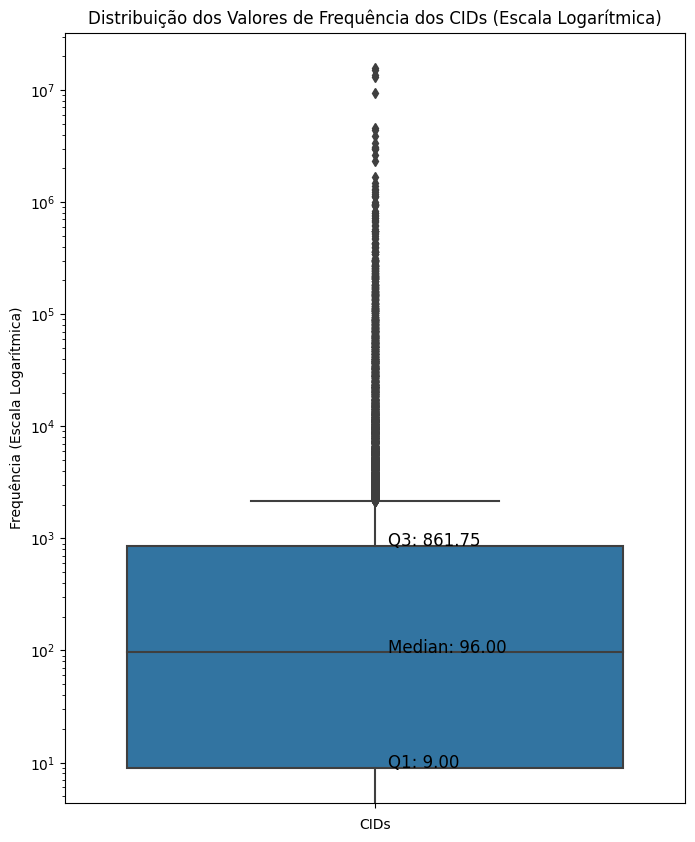

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que seu DataFrame seja 'df'
# Calcula a soma dos casos para cada CID
cid_frequencia = df.sum(axis=0)
cid_frequencia = cid_frequencia[3:]

# Calcula os quartis
q1 = cid_frequencia.quantile(0.25)
median = cid_frequencia.quantile(0.5)
q3 = cid_frequencia.quantile(0.75)

# Reseta o índice para transformar em DataFrame
cid_frequencia_df = cid_frequencia.reset_index()
cid_frequencia_df.columns = ['CID', 'Frequencia']

# Cria o boxplot vertical
plt.figure(figsize=(8, 10))
sns.boxplot(y=cid_frequencia_df['Frequencia'])

# Define a escala logarítmica no eixo Y
plt.yscale('log')

# Adiciona os valores dos quartis na imagem
plt.text(0.02, q1, f'Q1: {q1:.2f}', color='black', fontsize=12)
plt.text(0.02, median, f'Median: {median:.2f}', color='black', fontsize=12)
plt.text(0.02, q3, f'Q3: {q3:.2f}', color='black', fontsize=12)

# Título e rótulos
plt.title('Distribuição dos Valores de Frequência dos CIDs (Escala Logarítmica)')
plt.ylabel('Frequência (Escala Logarítmica)')
plt.xlabel('CIDs')

plt.show()


In [62]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
cid_frequencia_df.sort_values(by='Frequencia', ascending=False).head(50)

,CID,Frequencia
5773,CID (Z760) Emissão De Prescriç,15805404.0
556,CID (Z000) Exame Médico Geral,15200150.0
1789,CIAP (A98) Medicina Preventiva,13496096.0
9393,CID (I10) Hipertensão Essencia,13037340.0
3266,CIAP (K86) Hipertensão Sem Com,9492199.0
4794,CIAP (W78) Gravidez,4605265.0
557,CID (Z001) Exame De Rotina De,4376693.0
4738,CIAP (T90) Diabetes Não Insuli,3893121.0
1788,CIAP (A97) Sem Doença,3389638.0
7038,CID (E11) Diabetes Mellitus Nã,3108451.0


In [79]:
top_50_cids = cid_frequencia_df.sort_values(by='Frequencia', ascending=False)[:300]
cids =[]
for i in range(300):
    # get cids inside parenthesis
    cids.append(top_50_cids['CID'].iloc[i].split(')')[0] + ')' )
cids

['CID (Z760)',
 'CID (Z000)',
 'CIAP (A98)',
 'CID (I10)',
 'CIAP (K86)',
 'CIAP (W78)',
 'CID (Z001)',
 'CIAP (T90)',
 'CIAP (A97)',
 'CID (E11)',
 'CID (A90)',
 'CID (Z00)',
 'CIAP (A29)',
 'CID (Z008)',
 'CIAP (A99)',
 'CID (M545)',
 'CID (Z10)',
 'CID (J00)',
 'CIAP (P01)',
 'CIAP (R05)',
 'CID (Z014)',
 'CID (R05)',
 'CIAP (T89)',
 'CID (A09)',
 'CID (J069)',
 'CIAP (L03)',
 'CID (R51)',
 'CIAP (R80)',
 'CID (J11)',
 'CIAP (N01)',
 'CID (E10)',
 'CID (Z712)',
 'CID (Z017)',
 'CID (N390)',
 'CIAP (A77)',
 'CID (M255)',
 'CIAP (W14)',
 'CIAP (Z01)',
 'CID (R10)',
 'CID (E14)',
 'CID (E66)',
 'CID (E039)',
 'CIAP (A03)',
 'CIAP (L18)',
 'CID (J03)',
 'CIAP (D11)',
 'CIAP (T82)',
 'CIAP (P74)',
 'CID (M796)',
 'CIAP (X14)',
 'CIAP (R21)',
 'CID (E780)',
 'CID (R11)',
 'CID (E119)',
 'CIAP (W90)',
 'CIAP (K87)',
 'CID (T784)',
 'CIAP (P22)',
 'CIAP (P03)',
 'CIAP (D01)',
 'CID (H612)',
 'CIAP (X86)',
 'CIAP (L15)',
 'CID (E78)',
 'CIAP (T93)',
 'CID (J45)',
 'CIAP (P29)',
 'CID (M791)'

In [83]:
def seleciona_lista_cids(driver, cids):
    """Seleciona os cids da lista"""
    #try:
       # Clicar no botão de adicionar SIGTAB
    cid_button = driver.find_element(
        By.XPATH,
        '//*[@id="btnAddCid"]',
    )
    
    driver.execute_script("arguments[0].click();", cid_button)


    for  cid in cids:
        
        cid_input = WebDriverWait(driver, 3).until(
            EC.visibility_of_element_located(
                (By.XPATH, '//*[@id="dtBasicExample_filter"]/label/input')
            )
        )
        cid_input.clear()
        # Preencher o campo com o código do SIGTAB
        cid_input.send_keys(cid)

        # seleciona o checkbox
        cid_checkbox = WebDriverWait(driver, 3).until(
            EC.presence_of_element_located(
                (By.XPATH, '//*[@id="dtBasicExample"]/tbody/tr/td/label')
            )
        )

        if not cid_checkbox.is_selected():
            cid_checkbox.click()


    # Clica no botão de concluir
    concluir_button = WebDriverWait(driver, 3).until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="modal-default-cid"]/div/div/div[2]/button[2]')
        )
    )
    concluir_button.click()
  

    return True
    #except StaleElementReferenceException:
    #    return False
    




def executar_cid():
    """Executa o download dos relatórios de produção para cada mês."""
    # Inicializa o driver
    driver = cria_driver()
    # Esperar a página carregar
    wait = WebDriverWait(driver, 10)

    # Clica no botão de de competência (mes/ano)
    competencia_element = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, '//*[@id="competencia"]/div/button')
        )
    )
    driver.execute_script("arguments[0].click();", competencia_element)

    competencias = wait.until(
        EC.presence_of_element_located(
            ("xpath", '//*[@id="competencia"]/div/ul')
        )
    )

    for j in range(len(competencias.find_elements(By.TAG_NAME, "li"))):
        # recarregar competencias
        if j > 0:
            competencias = seleciona_competencias(driver)
        for i, competencia in enumerate(
            competencias.find_elements(By.TAG_NAME, "li")
        ):
            if i == j and i > 58:
                mes = competencia.text
                # pegar o horario de inicio em timestamp

                logger.info(f"Processando o mês {mes}")
                # Clica no botão de de competência (mes/ano)

                competencia.click()

                # Selecionar "Municípios" no dropdown de Linhas
                seleciona_xpath(driver, '//*[@id="selectLinha"]/optgroup[1]/option[5]')

                # Selecionar "CID" no dropdown de Colunas
                seleciona_xpath(driver, '//*[@id="selectcoluna"]/optgroup[2]/option[7]')

                # Selecionar o CIDs
                seleciona_lista_cids(driver, cids)
        try:
            fazer_download(driver, mes, "producao_cid")
        except Exception as e:
            print('Erro na execução: ', i)
            print(e)             
            driver.quit()
            driver = cria_driver()


    logger.info("Script Finalizado")
    # Fecha a janela do navegador
    driver.quit()

executar_cid()


2024-08-29 06:50:37,017 - INFO - ====== WebDriver manager ======
2024-08-29 06:50:37,078 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:50:37,113 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:50:37,154 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:50:37,750 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:50:40,064 - INFO - ====== WebDriver manager ======
2024-08-29 06:50:40,140 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:50:40,178 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:50:40,212 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:50:40,756 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:50:43,052 - INFO - ====== WebDriver manager ======
2024-08-29 06:50:43,122 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:50:43,154 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:50:43,190 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:50:43,739 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:50:46,050 - INFO - ====== WebDriver manager ======
2024-08-29 06:50:46,142 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:50:46,177 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:50:46,215 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:50:46,728 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:50:49,056 - INFO - ====== WebDriver manager ======
2024-08-29 06:50:49,128 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:50:49,165 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:50:49,197 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:50:49,777 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:50:52,140 - INFO - ====== WebDriver manager ======
2024-08-29 06:50:52,210 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:50:52,241 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:50:52,275 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:50:52,838 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:50:55,233 - INFO - ====== WebDriver manager ======
2024-08-29 06:50:55,306 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:50:55,338 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:50:55,371 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:50:55,929 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:50:58,287 - INFO - ====== WebDriver manager ======
2024-08-29 06:50:58,363 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:50:58,396 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:50:58,428 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:50:58,964 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:02,877 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:02,948 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:02,986 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:03,018 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:03,566 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:05,973 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:06,049 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:06,081 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:06,121 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:06,679 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:09,070 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:09,145 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:09,178 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:09,211 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:09,750 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:12,162 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:12,235 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:12,266 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:12,300 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:12,869 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:15,180 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:15,261 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:15,293 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:15,329 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:15,887 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:18,433 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:18,499 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:18,532 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:18,567 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:19,108 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:22,339 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:22,416 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:22,448 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:22,481 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:23,056 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:26,611 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:26,689 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:26,722 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:26,753 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:27,306 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:29,619 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:29,688 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:29,725 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:29,759 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:30,319 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:32,722 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:32,786 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:33,882 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:33,914 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:34,439 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:38,390 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:38,468 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:38,500 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:38,532 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:39,077 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:41,365 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:41,437 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:41,469 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:41,501 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:42,097 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:46,660 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:46,739 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:46,770 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:46,805 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:47,379 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:50,609 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:50,684 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:50,716 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:50,748 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:51,288 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:53,719 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:53,799 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:53,830 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:53,864 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:54,417 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:51:56,852 - INFO - ====== WebDriver manager ======
2024-08-29 06:51:56,923 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:51:56,957 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:51:56,993 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:51:57,524 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:00,039 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:00,120 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:00,154 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:00,189 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:00,758 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:04,342 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:04,416 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:04,450 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:04,485 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:05,014 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:09,846 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:09,926 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:09,958 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:09,990 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:10,567 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:14,409 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:14,479 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:14,513 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:14,545 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:15,107 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:21,143 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:21,218 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:21,251 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:21,284 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:21,858 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:27,238 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:27,321 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:27,353 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:27,393 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:27,929 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:32,812 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:32,891 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:32,925 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:32,959 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:33,500 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:37,636 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:37,717 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:37,750 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:37,783 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:38,388 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:42,260 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:42,332 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:42,365 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:42,402 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:42,985 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:46,850 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:46,931 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:46,963 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:46,996 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:47,527 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:50,666 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:50,742 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:50,781 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:50,814 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:51,409 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:52:57,283 - INFO - ====== WebDriver manager ======
2024-08-29 06:52:57,360 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:52:57,394 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:52:57,427 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:52:57,941 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:01,433 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:01,511 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:01,544 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:01,577 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:02,127 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:06,409 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:06,493 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:06,535 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:06,568 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:07,167 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:09,608 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:09,684 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:09,719 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:09,752 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:10,294 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:12,643 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:12,716 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:12,747 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:12,784 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:13,357 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:15,694 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:15,774 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:15,818 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:15,856 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:16,398 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:20,250 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:20,336 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:20,371 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:20,403 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:20,959 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:23,247 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:23,315 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:23,347 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:23,380 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:23,949 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:27,777 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:27,850 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:27,883 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:27,918 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:28,468 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:30,752 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:30,826 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:30,859 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:30,890 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:31,436 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:34,857 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:34,933 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:34,965 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:35,000 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:35,556 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:38,757 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:38,830 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:38,863 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:38,896 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:39,459 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:41,871 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:41,950 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:41,986 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:42,019 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:42,550 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:45,808 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:45,878 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:45,910 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:45,945 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:46,507 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:50,490 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:50,566 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:50,599 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:50,631 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:51,208 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:53:53,632 - INFO - ====== WebDriver manager ======
2024-08-29 06:53:53,716 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:53:53,749 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:53:53,783 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:53:54,358 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:00,129 - INFO - ====== WebDriver manager ======
2024-08-29 06:54:00,207 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:54:00,239 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:54:00,273 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:54:00,818 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:10,053 - INFO - ====== WebDriver manager ======
2024-08-29 06:54:10,134 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:54:10,179 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:54:10,216 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:54:10,760 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:21,019 - INFO - ====== WebDriver manager ======
2024-08-29 06:54:21,098 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:54:21,133 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:54:21,168 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:54:21,768 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:25,321 - INFO - ====== WebDriver manager ======
2024-08-29 06:54:25,399 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:54:25,434 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:54:25,467 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:54:26,036 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:28,466 - INFO - ====== WebDriver manager ======
2024-08-29 06:54:28,532 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:54:28,565 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:54:28,597 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:54:29,132 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:31,606 - INFO - ====== WebDriver manager ======
2024-08-29 06:54:31,675 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:54:31,707 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:54:31,741 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:54:32,309 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:34,557 - INFO - ====== WebDriver manager ======
2024-08-29 06:54:34,628 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:54:34,662 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:54:34,696 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:54:35,226 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:38,200 - INFO - ====== WebDriver manager ======
2024-08-29 06:54:38,269 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:54:38,301 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:54:38,335 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:54:38,890 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:41,291 - INFO - ====== WebDriver manager ======
2024-08-29 06:54:41,363 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 06:54:41,398 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
local variable 'mes' referenced before assignment


2024-08-29 06:54:41,430 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 06:54:41,967 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 06:54:44,262 - INFO - Processando o mês AGO/2019
2024-08-29 06:56:30,482 - INFO - Fazendo download do relatório para AGO/2019
2024-08-29 07:01:30,693 - INFO - ====== WebDriver manager ======
2024-08-29 07:01:30,772 - INFO - Get LATEST chromedriver version for google-chrome


Erro na execução:  135
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=128.0.6613.84)
Stacktrace:
#0 0x562ca9bb98da <unknown>
#1 0x562ca9887e50 <unknown>
#2 0x562ca986fe20 <unknown>
#3 0x562ca986fb0d <unknown>
#4 0x562ca986db11 <unknown>
#5 0x562ca986e31f <unknown>
#6 0x562ca987de3b <unknown>
#7 0x562ca9894204 <unknown>
#8 0x562ca989974b <unknown>
#9 0x562ca986ea2e <unknown>
#10 0x562ca9894059 <unknown>
#11 0x562ca991ac2b <unknown>
#12 0x562ca98fc233 <unknown>
#13 0x562ca98ca093 <unknown>
#14 0x562ca98cb09e <unknown>
#15 0x562ca9b80b3b <unknown>
#16 0x562ca9b84af1 <unknown>
#17 0x562ca9b6c705 <unknown>
#18 0x562ca9b85662 <unknown>
#19 0x562ca9b518df <unknown>
#20 0x562ca9ba86d8 <unknown>
#21 0x562ca9ba88a2 <unknown>
#22 0x562ca9bb86cc <unknown>
#23 0x7fd30b5beac3 <unknown>



2024-08-29 07:01:30,820 - INFO - Get LATEST chromedriver version for google-chrome
2024-08-29 07:01:30,856 - INFO - Driver [/home/daniel/.wdm/drivers/chromedriver/linux64/128.0.6613.86/chromedriver] found in cache
2024-08-29 07:01:31,384 - INFO - Iniciando o acesso a página de Producao do SISAB
2024-08-29 07:01:33,782 - INFO - Processando o mês JUL/2019
2024-08-29 07:03:21,223 - INFO - Fazendo download do relatório para JUL/2019
2024-08-29 07:05:46,829 - INFO - Download completo: RelatorioSaudeProducao.csv
2024-08-29 07:05:47,000 - INFO - Processando o mês JUN/2019
2024-08-29 07:07:37,826 - INFO - Fazendo download do relatório para JUN/2019
2024-08-29 07:10:38,451 - INFO - Processando o mês MAI/2019


Tempo limite excedido para download de RelatorioSaudeProducao.csv.


2024-08-29 07:12:33,174 - INFO - Fazendo download do relatório para MAI/2019
2024-08-29 07:15:21,883 - INFO - Download completo: RelatorioSaudeProducao.csv
2024-08-29 07:15:22,113 - INFO - Processando o mês ABR/2019
2024-08-29 07:17:18,445 - INFO - Fazendo download do relatório para ABR/2019
2024-08-29 07:20:19,074 - INFO - Processando o mês MAR/2019


Tempo limite excedido para download de RelatorioSaudeProducao.csv.


ElementNotInteractableException: Message: element not interactable
  (Session info: chrome=128.0.6613.84)
Stacktrace:
#0 0x55aee8bde8da <unknown>
#1 0x55aee88acc91 <unknown>
#2 0x55aee88fd92f <unknown>
#3 0x55aee88f14d6 <unknown>
#4 0x55aee8921492 <unknown>
#5 0x55aee88f0e89 <unknown>
#6 0x55aee892165e <unknown>
#7 0x55aee893f9c6 <unknown>
#8 0x55aee8921233 <unknown>
#9 0x55aee88ef093 <unknown>
#10 0x55aee88f009e <unknown>
#11 0x55aee8ba5b3b <unknown>
#12 0x55aee8ba9af1 <unknown>
#13 0x55aee8b91705 <unknown>
#14 0x55aee8baa662 <unknown>
#15 0x55aee8b768df <unknown>
#16 0x55aee8bcd6d8 <unknown>
#17 0x55aee8bcd8a2 <unknown>
#18 0x55aee8bdd6cc <unknown>
#19 0x7f887c734ac3 <unknown>
